# Image Processing Assignment 2

<ul>
Bereket Kebede, Grad student <br>
University of Memphis, Spring 2022 <br>
Instructor: Dr. Yeasin <br>
    </ul>

## Question 1

### Histogram Equalization & Histogram Specification

**Instruction:** Write computer programs to perform “Histogram Equalization” and “Histogram Specification” 
compare the performance of your program with the OpenCV output on same images.  Show 
where classic histogram equalization fails to produce desired results. Implement local histogram 
equalization. Show in some cases local histogram will do better job in improving the contrast of 
the image.

> Logic: Histogram equalization automatically determines a transformation function that seeks to produce an output image that has a uniform histogram. When automatic enhancement is desired, this is a good approach because the results from this technique are predictable and the method is simple to implement.

In [132]:
##################################################
# Import necessary libraries

import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from tqdm import tqdm
from skimage import data
from scipy import ndimage
from skimage.exposure import match_histograms

In [159]:
##################################################
# Defining functions


# Function: takes in a 2d image and returns the image's histogram vector of 256x1, bins = 255
def make_histogram(img):   
    
    histogram = np.zeros((256,), dtype=int)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            histogram[img[i,j]] += 1 #index the bins and populate the bucket based on intensity value of a pixel
    return histogram


# Function: takes in a 2d image and returns the image's normalized histogram vector of 256x1, bins = 255
def make_norm_histogram(img):   
    
    histogram = np.zeros((256,), dtype=int)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            histogram[img[i,j]] += 1 #index the bins and populate the bucket based on intensity value of a pixel
    return histogram/(img.shape[0]*img.shape[1])

# Function: finds cumulative sum of a numpy array, list
def cumsum(h):
  
    return [sum(h[:i+1]) for i in range(len(h))]

# Function: takes in a 2d image and returns equalized histogram
def hist_eq(im):
    #calculate Histogram
    h = make_norm_histogram(im)
    cdf = np.array(cumsum(h)) #cumulative distribution function
    
    # We can now use the normalized cumulative sum to modify the intensity values of our original image.
    sk = np.uint8(255 * cdf) #finding transfer function values
    s1, s2 = im.shape
    Y = np.zeros_like(im)
    # applying transfered values for each pixels
    for i in range(0, s1):
        for j in range(0, s2):
            Y[i, j] = sk[im[i, j]]
    H = make_norm_histogram(Y)
    #return transformed image, original and new histogram, 
    # and transform function
    return Y, h, H, sk


def local_histeq(img, kernel):
    M, N = img.shape
    x, y = kernel
    eq_img = np.copy(img)
    for i in range(0,M-x,x):
        for j in range(0,N-y,y):
            img_eq = np.copy(eq_img[i:i+x, j:j+y])
            
            _, eq_img[i:i+x, j:j+y], _ = hist_eq(img_eq)
    eq_img = scale_img(eq_img)      
    return eq_img


def apply_filter(img, kernel, kernel_type):
    M, N = img.shape
    x, y = kernel.shape
    e_img = np.copy(img)
    filtered_img = np.zeros((M,N))

    e_img = np.pad(e_img, [(0, x-1), (0, y-1)])

    
    if kernel_type == 'median':
        for i in range(M):
            for j in range(N):
                k_vals = e_img[i:i+x, j:j+y].flatten()
                med_val = np.median(k_vals)
                filtered_img[i,j] = med_val
                
    if kernel_type == 'mean':
        kernel = (1/np.sum(kernel))*kernel
        for i in range(M):
            for j in range(N):
                ip = np.multiply(e_img[i:i+x, j:j+y], kernel, dtype=np.float32)
                avg_val = np.sum(ip)
                filtered_img[i,j] = avg_val
                
    if kernel_type == 'filter':
        for i in range(M):
            for j in range(N):
                ip = np.multiply(e_img[i:i+x, j:j+y], kernel, dtype=np.float32)
                avg_val = np.sum(ip)
                filtered_img[i,j] = avg_val
    return scale_img(filtered_img)    

def plot_hist(hist):
    plt.figure(figsize=(8,6))
    plt.bar(list(range(0,256)), hist)
    plt.show()
    
def scale_img(img, qmin=0, qmax=255):
    max_val = img.max()
    min_val = img.min()
    scaled_img = ((img - min_val)/(max_val - min_val)) * (qmax - qmin)
    
    return scaled_img.astype(np.uint8)

def SNR(image):
    mean = np.mean(image)
    variance = np.var(image)
    metrics = mean/variance
    return round(metrics,4)

def mse(imageA, imageB, round_flag):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # The two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    err /= (255*255)
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return round(err, round_flag)

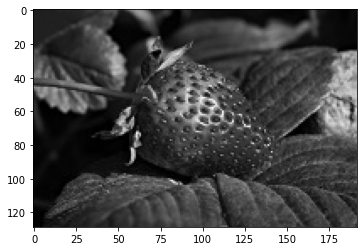

In [36]:
##################################################
# Display original image

img = cv2.imread('Data/straw_2.jpg', cv2.IMREAD_GRAYSCALE)
plt.figure()
plt.imshow(img, cmap=cm.gray)

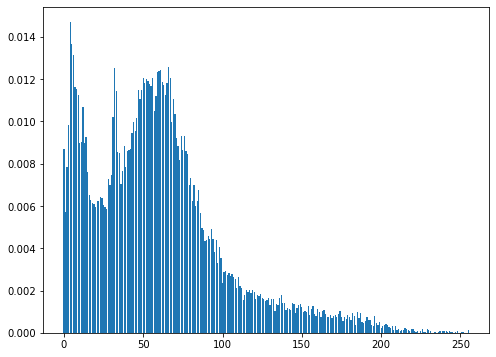

In [71]:
hist = make_norm_histogram(img)
plot_hist(hist)

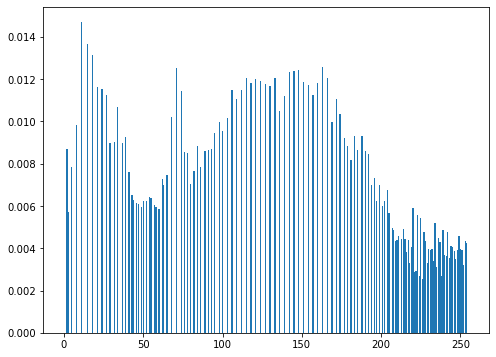

In [70]:
eq_img, h, new_h, sk = hist_eq(img)
plot_hist(new_h)

Text(0.5, 1.0, 'Equalize histogram using histogram equlaizer written from scratch')

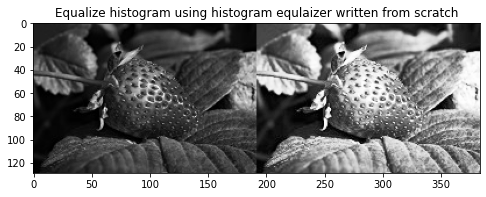

In [84]:
f_img = np.hstack((img, eq_img))
plt.figure(figsize=(8,6))
plt.imshow(f_img, cmap=cm.gray)
plt.title('Equalize histogram using histogram equlaizer written from scratch')

Text(0.5, 1.0, 'Equalize histogram using cv2 library')

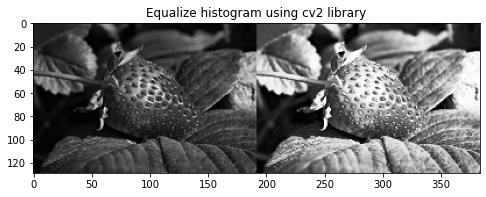

In [81]:
##################################################
# Equalize histogram using cv2 library

cv2_equ = cv2.equalizeHist(img)
res = np.hstack((img,cv2_equ)) #stacking images side-by-side
plt.figure(figsize=(8,6))
plt.imshow(res, cmap=cm.gray)
plt.title('Equalize histogram using cv2 library')

In [79]:
mse(cv2_equ,eq_img, 5)

1e-05

In [62]:
print(SNR(cv2_equ))
print(SNR(eq_img))

0.0233
0.0238


### Local Histogram Equalization

> Logic: The procedure is to define a square or rectangular neighborhood and move the center of this area from pixel to pixel. At each location, the histogram of the points in the neighborhood is computed and either a histogram equalization or histogram specification transformation function is obtained. This function is finally used to map the gray level of the pixel centered
in the neighborhood.The center of the neighborhood region is then moved to an adjacent pixel location and the procedure is repeated.

Gonzalez pg. 103

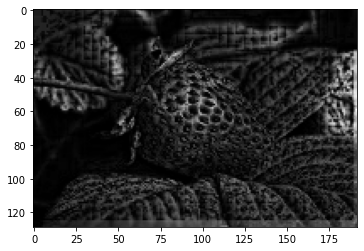

In [47]:
local_eq_img = local_histeq(img, (5,5))
plt.imshow(local_eq_img, cmap=cm.gray)

##  Histogram Specification

> Logic: There are applications in which attempting to base enhancement on a uniform histogram is not the best approach. In particular, it is useful sometimes to be able to specify the shape of the histogram that we wish the processed image to have.The method used to generate a processed image that has a specified histogram is called histogram matching or histogram specification.

Text(0.5, 1.0, 'Matched Image')

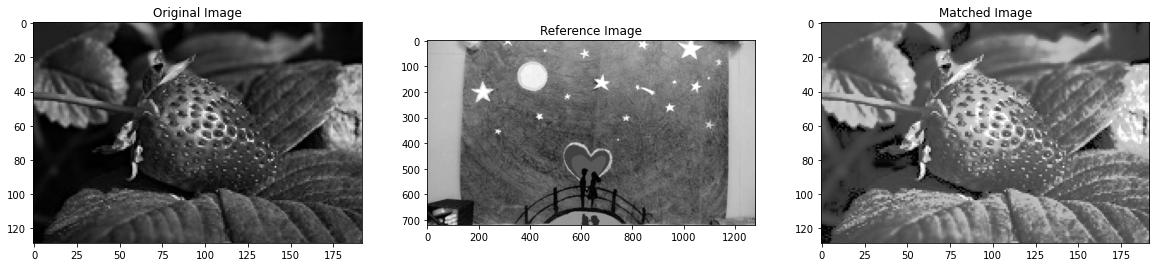

In [151]:
##################################################
# pre-defined library implementation

img = cv2.imread('Data/straw_2.jpg', cv2.IMREAD_GRAYSCALE)
ref_image = cv2.imread('data/paint.jpg', cv2.IMREAD_GRAYSCALE)
matched = match_histograms(img, ref_image, multichannel=False,)

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20,10))

axs[0].imshow(img, cmap=cm.gray)
axs[0].set_title('Original Image')
axs[1].imshow(ref_image, cmap=cm.gray)
axs[1].set_title('Reference Image')
axs[2].imshow(matched, cmap=cm.gray)
axs[2].set_title('Matched Image')

In [152]:
mse(img,matched,5)

0.05411

## Question 2
----

**Instruction:** Implement “Mean and Median Filter” in enhancing the quality of images.  Show the effect of 
different window sizes in your output and explain the results you observe in your reports.

> Logic: Median filters: which, as its name implies, replaces the value of a pixel by the median of the gray levels in the neighborhood of that pixel. Median filters are quite popular because, for certain types of random noise, they provide excellent noise-reduction capabilities, with considerably less blurring than linear smoothing filters of similar size. Median filters are particularly effective in the presence of impulse noise, also called salt-and-pepper noise because of its appearance as white and black dots superimposed on an image. [4] <br> <br> Mean Filter: The arithmetic mean filter computes the average of the neighbours.

> Algorithm: Median Filter: For example, suppose that a 3*3 neighborhood has values (10, 20, 20, 20, 15, 20, 20, 25, 100). These values are sorted as (10, 15, 20, 20, 20, 20, 20, 25, 100), which results in a median of 20. Thus, the principal function of median filters is to force points with distinct gray levels to be more like their neighbors. <br><br> Mean Filter: Similar algorithm as median filter but takes the mean instead.


[4] Pg. 123, Gonzalez 2nd edition

(619, 512)

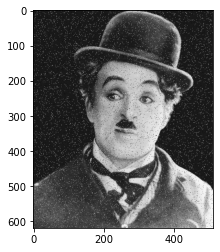

In [153]:
noisy_img = cv2.imread('data/Chaplin.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(noisy_img, cmap=cm.gray)
noisy_img.shape

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:45<00:00,  5.74s/it]


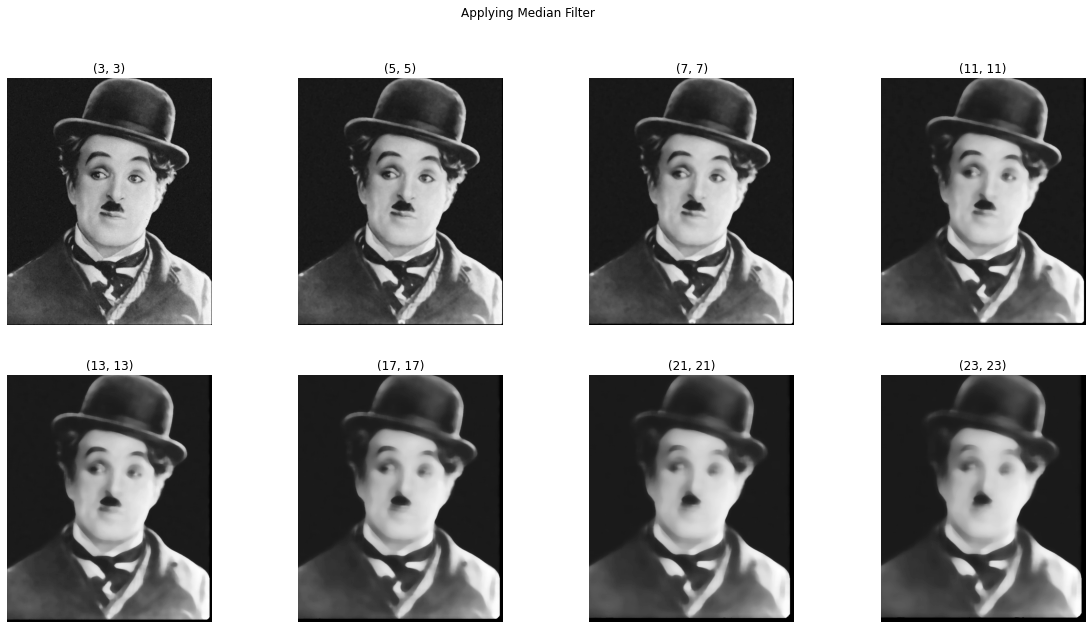

In [155]:
kernel_sizes = [(3,3), (5,5), (7,7), (11,11), (13, 13), (17,17), (21, 21), (23, 23)]
f_imgs = []

for kernel_size in tqdm(kernel_sizes):
    kernel = np.zeros(kernel_size)
    f_imgs.append(apply_filter(noisy_img, kernel, 'median'))
    
    
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,10))
plt.suptitle('Applying Median Filter')
for i, ax in zip(range(len(f_imgs)), axs.flatten()):
    ax.set_title(kernel_sizes[i])
    ax.imshow(f_imgs[i], cmap=cm.gray)
    ax.axis('off')

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:14<00:00,  1.82s/it]


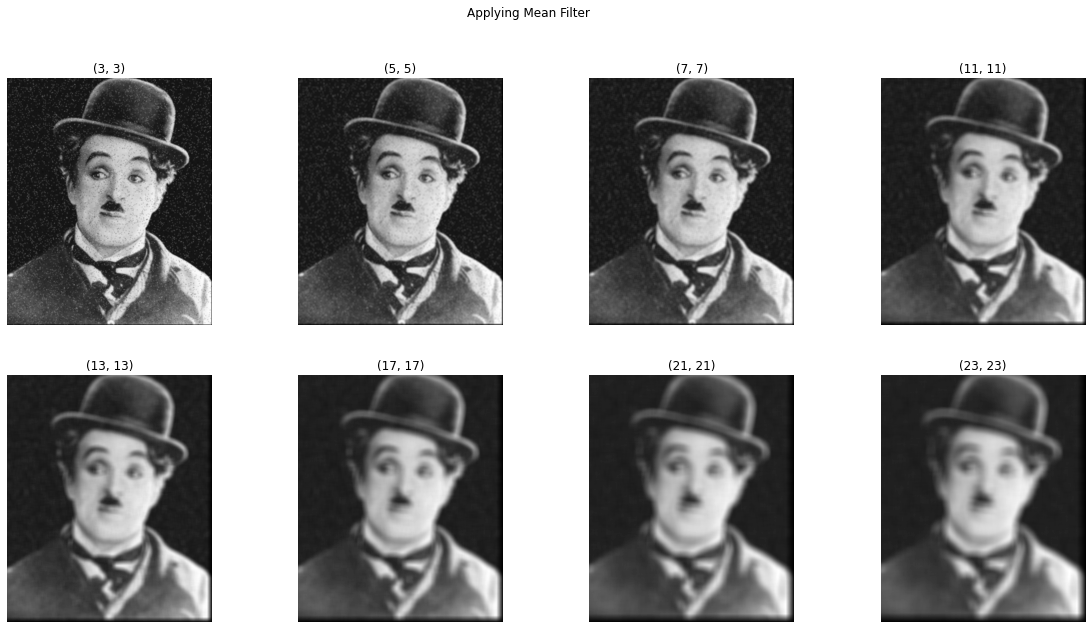

In [158]:
kernel_sizes = [(3,3), (5,5), (7,7), (11,11), (13, 13), (17,17), (21, 21), (23, 23)]
f_imgs = []

for kernel_size in tqdm(kernel_sizes):
    kernel = np.ones(kernel_size)
    f_imgs.append(apply_filter(noisy_img, kernel, 'mean'))
    
    
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,10))
plt.suptitle('Applying Mean Filter')
for i, ax in zip(range(len(f_imgs)), axs.flatten()):
    ax.set_title(kernel_sizes[i])
    ax.imshow(f_imgs[i], cmap=cm.gray)
    ax.axis('off')

## Question 3

### High pass Filtering


Create the mask of simple 5x5 and 7x7 high pass filter. Apply the mask to enhance the finer 
details of the image. Modify the masks to perform “High Boost Filtering”. Make sure you don’t 
do more than one pass over the image.

Logic: A high pass filter (HPF) is a filter that examines a region of an image and boosts the intensity of certain pixels based on the difference in the intensity with the surrounding pixels. HPF filters helps in finding edges in the images.

High-pass filter removes low frequency, whereas High-boost filter focuses on amplifying high-frequencies.

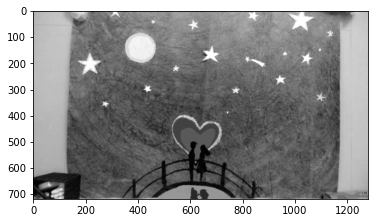

In [99]:
img = cv2.imread('data/paint.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=cm.gray)

In [123]:
HP_5x5_kernel = np.array([[0,-1,-1,-1,0],
                      [-1,2,-4,2,-1],
                      [-1,-4,20,-4,-1],
                      [-1,2,-4,2,-1],
                      [0,-1,-1,-1,0]])

HP_7x7_kernel = np.array([[1,0,0,1,0,0,1],
                      [0,2,0,2,0,2,0],
                      [0,0,4,4,4,0,0],
                      [0,0,0,-42,0,0,0],
                      [0,0,4,4,4,0,0],
                      [0,2,0,2,0,2,0],
                      [1,0,0,1,0,0,1]])

print(np.sum(HP_5x5_kernel))
print(np.sum(HP_7x7_kernel))

0
0


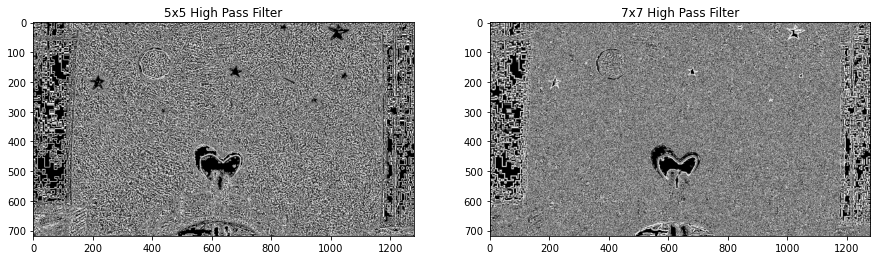

In [124]:
k5 = ndimage.convolve(img, HP_5x5_kernel)
k7 = ndimage.convolve(img, HP_7x7_kernel)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

ax1.set_title("5x5 High Pass Filter")
ax1.imshow(k5, cmap=cm.gray)

ax2.set_title("7x7 High Pass Filter")
ax2.imshow(k7, cmap=cm.gray)

In [125]:
HB_5x5_kernel = np.array([[0,-1,-1,-1,0],
                      [-1,2,-4,2,-2],
                      [-1,-4,23,-4,-1],
                      [-1,2,-4,2,-1],
                      [0,-1,-1,-1,0]])

HB_7x7_kernel = np.array([[1,0,0,1,0,0,1],
                      [0,2,0,2,0,2,0],
                      [0,0,4,4,4,0,0],
                      [0,0,0,-40,0,0,0],
                      [0,0,4,4,4,0,0],
                      [0,2,0,2,0,2,0],
                      [1,0,0,1,0,0,1]])

print(np.sum(HB_5x5_kernel))
print(np.sum(HB_7x7_kernel))

2
2


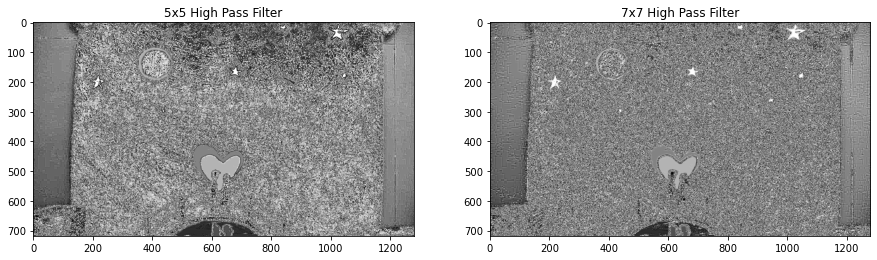

In [126]:
k5 = ndimage.convolve(img, HB_5x5_kernel)
k7 = ndimage.convolve(img, HB_7x7_kernel)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

ax1.set_title("5x5 High Pass Filter")
ax1.imshow(k5, cmap=cm.gray)

ax2.set_title("7x7 High Pass Filter")
ax2.imshow(k7, cmap=cm.gray)

## Question 4

### Edge detecting using sobel operator

Instruction: Implement Horizontal, vertical and diagonal edge detector using Sobel operator. Explain the 
results in your report.

> Logic: 

Sobel operator uses a weight value of 2, that is used to achieve some smoothing by giving more importance to the center point.

> Algorithm:

![ex](Images/sobel.png)

Reference: Pg. 578, Img Proc. Gonzalez 2nd edition

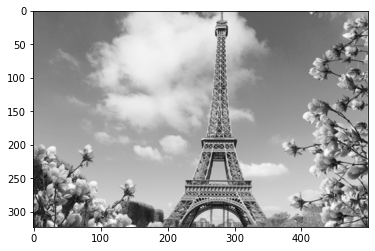

In [7]:
img = cv2.imread('data/paris.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap=cm.gray)

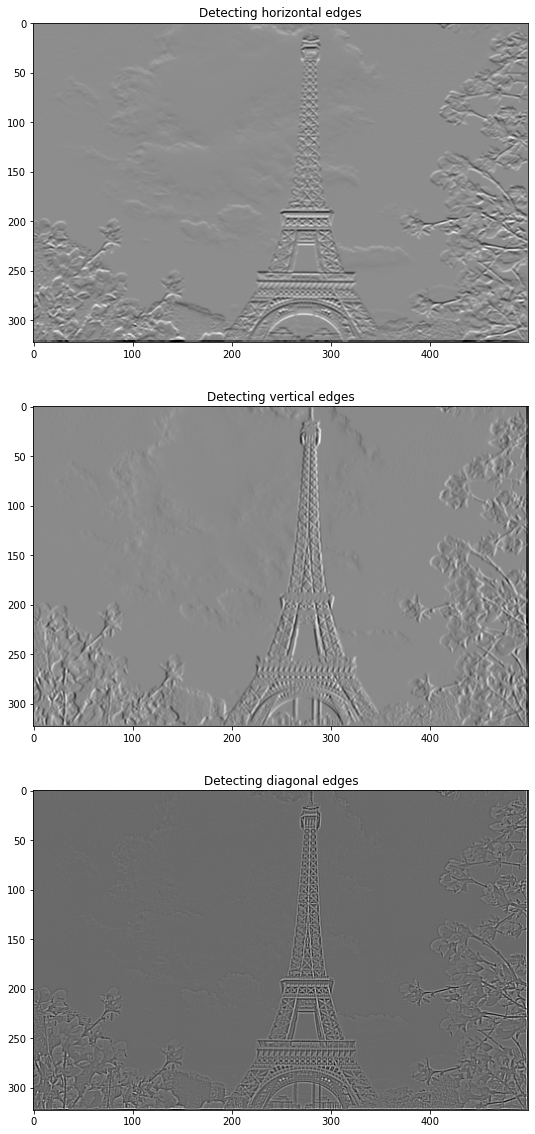

In [9]:
horizontal_kernel_3x3 = np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
vertical_kernel_3x3 = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
diagonal_kernel_3x3 = np.array([[-1,0,-1], [0,4,0],[-1,0,-1]])

f_img_h = apply_filter(img, horizontal_kernel_3x3, 'filter')
f_img_v = apply_filter(img, vertical_kernel_3x3, 'filter')
f_img_d = apply_filter(img, diagonal_kernel_3x3, 'filter')

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(20,20))

ax1.set_title("Detecting horizontal edges")
ax1.imshow(f_img_h, cmap=cm.gray)

ax2.set_title("Detecting vertical edges")
ax2.imshow(f_img_v, cmap=cm.gray)

ax3.set_title("Detecting diagonal edges")
ax3.imshow(f_img_d, cmap=cm.gray)

#### Reference:

[1] Paris Image: https://www.frommers.com/system/media_items/attachments/000/866/648/s500/Eiffel_Tower_Paris_France.jpg?1613010378  <br>
[2] Histogram equalization: https://gist.github.com/bistaumanga/6309599  <br>
[3] Histogram equalization: https://medium.com/hackernoon/histogram-equalization-in-python-from-scratch-ebb9c8aa3f23 <br>
[4] Main Ref Book: Digital Image Processing, Gonzalez 2nd edition <br>
[5] High-pass filters: https://www.opengl.org/archives/resources/code/samples/advanced/advanced97/notes/node168.html <br>
[6] High-pass filter kernels: https://rsdharra.com/blog/lesson/8.html